# Exceptions Analysis: Investigating Result Inconsistencies\n
\n
This notebook investigates three key exceptions in the authorship attribution results:\n
\n
1. **News Domain Mixed Results**: Why does News show weaker/inconsistent performance?\n
2. **Phi-2 Overall Strength**: What explains Phi-2's consistently strong performance?\n
3. **Weak Self-Separation Cases**: \n
   - News Falcon: Why does Falcon underperform in self-separation for News?\n
   - Abstracts R1: Why does R1 struggle to separate Human text in Abstracts?

In [2]:
# Import utilities
import importlib
import analysis_utils
importlib.reload(analysis_utils)
from analysis_utils import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew, pearsonr
from scipy.stats import gaussian_kde
from tabulate import tabulate

# Set style
sns.set_palette('colorblind')
plt.rcParams['figure.dpi'] = 100

## Load Dataset Paths

In [3]:
# Paths organized by: [separator_idx][author_idx]
# Separators: Llama-3.1 (0), Falcon (1), Phi-2 (2), DeepSeek-R1 (3)
# Authors: Llama3.1 (0), Falcon (1), Human (2), GPT (3), R1 (4)

wiki_paths = [
    [ 
      "Responses/wiki_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
      "Responses/wiki_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
      "Responses/wiki_human_text_none_Meta-Llama-3.1-8B-Instruct.csv",
      "Responses/wiki_gpt_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
      "Responses/wiki_R1_clean_none_Meta-Llama-3.1-8B-Instruct.csv"
    ],
    [ 
      "Responses/wiki_Llama3.1_clean_none_falcon-7b.csv",
      "Responses/wiki_Falcon_clean_none_falcon-7b.csv",
      "Responses/wiki_human_text_none_falcon-7b.csv",
      "Responses/wiki_gpt_clean_none_falcon-7b.csv",
      "Responses/wiki_R1_clean_none_falcon-7b.csv"
    ],
    [ 
      "Responses/wiki_Llama3.1_clean_none_phi-2.csv",
      "Responses/wiki_Falcon_clean_none_phi-2.csv",
      "Responses/wiki_human_text_none_phi-2.csv",
      "Responses/wiki_gpt_clean_none_phi-2.csv",
      "Responses/wiki_R1_clean_none_phi-2.csv"
    ],
    [ 
      "Responses/wiki_Llama3.1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
      "Responses/wiki_Falcon_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
      "Responses/wiki_human_text_none_DeepSeek-R1-Distill-Qwen-7B.csv",
      "Responses/wiki_gpt_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
      "Responses/wiki_R1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv"
    ]
]

news_paths = [
    [
    "Responses/news_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
    "Responses/news_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
    "Responses/news_human_text_none_Meta-Llama-3.1-8B-Instruct.csv",
    "Responses/news_gpt_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
    "Responses/news_R1_clean_none_Meta-Llama-3.1-8B-Instruct.csv"
    ],
    [
    "Responses/news_Llama3.1_clean_none_falcon-7b.csv",
    "Responses/news_Falcon_clean_none_falcon-7b.csv",
    "Responses/news_human_text_none_falcon-7b.csv",
    "Responses/news_gpt_clean_none_falcon-7b.csv",
    "Responses/news_R1_clean_none_falcon-7b.csv"
    ],
    [
    "Responses/news_Llama3.1_clean_none_phi-2.csv",
    "Responses/news_Falcon_clean_none_phi-2.csv",
    "Responses/news_human_text_none_phi-2.csv",
    "Responses/news_gpt_clean_none_phi-2.csv",
    "Responses/news_R1_clean_none_phi-2.csv"
    ],
    [
    "Responses/news_Llama3.1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
    "Responses/news_Falcon_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
    "Responses/news_human_text_none_DeepSeek-R1-Distill-Qwen-7B.csv",
    "Responses/news_gpt_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
    "Responses/news_R1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv"
    ]
]

abstracts_paths = [
    [
    "Responses/abstracts_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
    "Responses/abstracts_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
    "Responses/abstracts_human_text_none_Meta-Llama-3.1-8B-Instruct.csv",
    "Responses/abstracts_gpt_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
    "Responses/abstracts_R1_clean_none_Meta-Llama-3.1-8B-Instruct.csv"
    ],
    [
    "Responses/abstracts_Llama3.1_clean_none_falcon-7b.csv",
    "Responses/abstracts_Falcon_clean_none_falcon-7b.csv",
    "Responses/abstracts_human_text_none_falcon-7b.csv",
    "Responses/abstracts_gpt_clean_none_falcon-7b.csv",
    "Responses/abstracts_R1_clean_none_falcon-7b.csv"
    ],
    [
    "Responses/abstracts_Llama3.1_clean_none_phi-2.csv",
    "Responses/abstracts_Falcon_clean_none_phi-2.csv",
    "Responses/abstracts_human_text_none_phi-2.csv",
    "Responses/abstracts_gpt_clean_none_phi-2.csv",
    "Responses/abstracts_R1_clean_none_phi-2.csv"
    ],
    [
    "Responses/abstracts_Llama3.1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
    "Responses/abstracts_Falcon_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
    "Responses/abstracts_human_text_none_DeepSeek-R1-Distill-Qwen-7B.csv",
    "Responses/abstracts_gpt_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
    "Responses/abstracts_R1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv"
    ]
]

# Section 1: News Domain Comprehensive Analysis

**Goal**: Understand why News domain shows mixed/weak results compared to Wiki and Abstracts.

We'll investigate:
1. Log-perplexity characteristics (noise, variance)
2. Text characteristics (sentence length, diversity)
3. Distribution overlap (JS divergence)

### 1.1 Log-Perplexity Characteristics

In [43]:
# Compute domain-level log-ppx statistics
domain_names = ['Wiki', 'News', 'Abstracts']
domain_paths_list = [wiki_paths, news_paths, abstracts_paths]

domain_metrics = []
for domain_name, paths in zip(domain_names, domain_paths_list):
    all_responses = []
    for sep_paths in paths:
        for author_path in sep_paths:
            df = pd.read_csv(author_path)
            all_responses.extend(df['response'].dropna().values)
    
    mean_logppx = np.mean(all_responses)
    std_logppx = np.std(all_responses)
    cv = std_logppx / abs(mean_logppx)
    
    domain_metrics.append({
        'Domain': domain_name,
        'Mean Log-ppx': mean_logppx,
        'STD Log-ppx': std_logppx,
        'Variability Coefficient': cv
    })

domain_df = pd.DataFrame(domain_metrics)
print("\nDomain Log-Perplexity Statistics:")
print("="*70)
print(tabulate(domain_df, headers='keys', tablefmt='simple', showindex=False, floatfmt='.4f'))
print("="*70)


Domain Log-Perplexity Statistics:
Domain       Mean Log-ppx    STD Log-ppx    Variability Coefficient
---------  --------------  -------------  -------------------------
Wiki               2.9915         1.3076                     0.4371
News               3.6617         1.9259                     0.5259
Abstracts          3.1949         1.1633                     0.3641


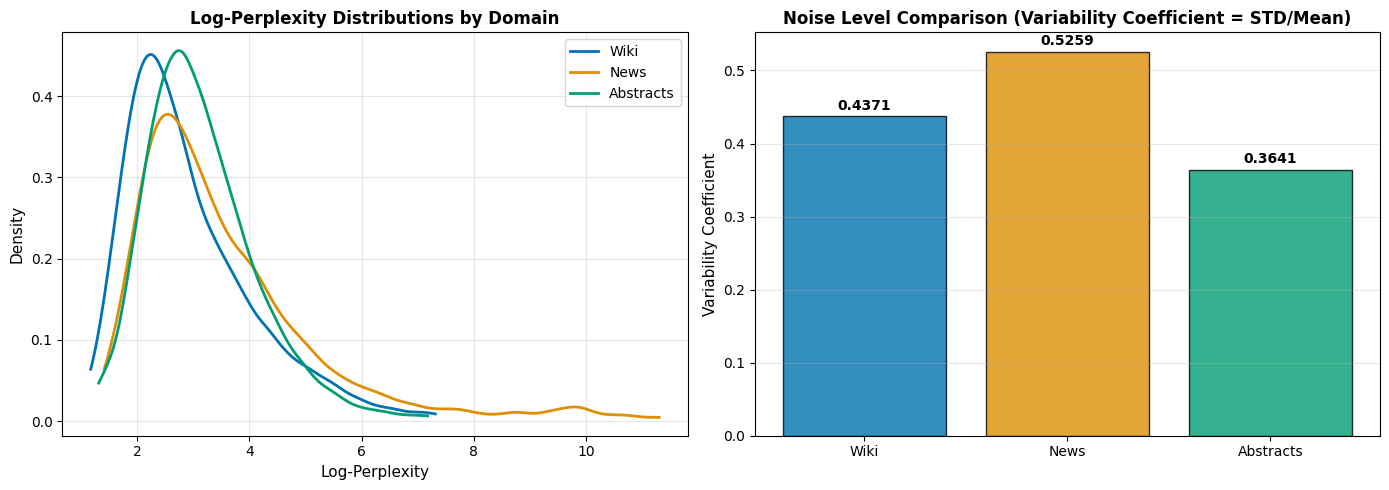

In [25]:
# Visualize log-ppx distributions and CV comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overlayed KDE plots
ax1 = axes[0]
colors = sns.color_palette('colorblind', 3)

for (domain_name, paths), color in zip(zip(domain_names, domain_paths_list), colors):
    all_responses = []
    for sep_paths in paths:
        for author_path in sep_paths:
            df = pd.read_csv(author_path)
            all_responses.extend(df['response'].dropna().values)
    
    # Sample for efficiency if needed
    if len(all_responses) > 50000:
        all_responses = np.random.choice(all_responses, 50000, replace=False)
    
    kde = gaussian_kde(all_responses)
    x_range = np.linspace(np.percentile(all_responses, 1), 
                          np.percentile(all_responses, 99), 200)
    ax1.plot(x_range, kde(x_range), label=domain_name, color=color, linewidth=2)

ax1.set_xlabel('Log-Perplexity', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title('Log-Perplexity Distributions by Domain', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Plot 2: Variability Coefficient comparison
ax2 = axes[1]
bars = ax2.bar(domain_df['Domain'], domain_df['Variability Coefficient'], color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('Variability Coefficient', fontsize=11)
ax2.set_title('Noise Level Comparison (Variability Coefficient = STD/Mean)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, domain_df['Variability Coefficient']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('images/exceptions_news_logppx_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### 1.2 Text Characteristics

In [26]:
# Load cleaned datasets and analyze text characteristics
wiki_clean = pd.read_csv('src/wiki_dataset_clean.csv')
news_clean = pd.read_csv('src/news_dataset_clean.csv')
abstracts_clean = pd.read_csv('src/abstracts_dataset_clean.csv')

def analyze_text_characteristics(df, domain_name):
    """
    Analyzes text length and diversity from cleaned datasets.
    """
    def get_unique_words(text):
        """Extract unique words from text"""
        if pd.isna(text) or text == '':
            return set()
        return set(str(text).lower().split())
    
    # Parse length tuples (word_count, sentence_count)
    human_lens = np.array(df['human_len'].apply(eval).tolist())
    llama_lens = np.array(df['Llama3.1_clean_len'].apply(eval).tolist())
    falcon_lens = np.array(df['Falcon_clean_len'].apply(eval).tolist())
    r1_lens = np.array(df['R1_clean_len'].apply(eval).tolist())
    
    # Extract word and sentence counts
    human_words = human_lens[:, 0]
    human_sentences = human_lens[:, 1]
    llama_words = llama_lens[:, 0]
    llama_sentences = llama_lens[:, 1]
    falcon_words = falcon_lens[:, 0]
    falcon_sentences = falcon_lens[:, 1]
    r1_words = r1_lens[:, 0]
    r1_sentences = r1_lens[:, 1]
    
    # Compute unique words per article for diversity
    human_texts = df['human_text'].dropna()
    human_unique_per_article = [len(get_unique_words(text)) for text in human_texts]
    
    llama_texts = df['Llama3.1_clean'].dropna()
    llama_unique_per_article = [len(get_unique_words(text)) for text in llama_texts]
    
    falcon_texts = df['Falcon_clean'].dropna()
    falcon_unique_per_article = [len(get_unique_words(text)) for text in falcon_texts]
    
    r1_texts = df['R1_clean'].dropna()
    r1_unique_per_article = [len(get_unique_words(text)) for text in r1_texts]
    
    results = {
        'Domain': domain_name,
        'Human Mean Words': np.mean(human_words),
        'Human Mean Sentences': np.mean(human_sentences),
        'Llama Mean Words': np.mean(llama_words),
        'Llama Mean Sentences': np.mean(llama_sentences),
        'Falcon Mean Words': np.mean(falcon_words),
        'Falcon Mean Sentences': np.mean(falcon_sentences),
        'R1 Mean Words': np.mean(r1_words),
        'R1 Mean Sentences': np.mean(r1_sentences),
        'Human Mean Unique/Article': np.mean(human_unique_per_article),
        'Llama Mean Unique/Article': np.mean(llama_unique_per_article),
        'Falcon Mean Unique/Article': np.mean(falcon_unique_per_article),
        'R1 Mean Unique/Article': np.mean(r1_unique_per_article)
    }
    
    return results

# Analyze all domains
text_metrics = []
for df, name in [(wiki_clean, 'Wiki'), (news_clean, 'News'), (abstracts_clean, 'Abstracts')]:
    text_metrics.append(analyze_text_characteristics(df, name))

text_df = pd.DataFrame(text_metrics)
print("\nText Length and Diversity Characteristics:")
print("="*140)
print(tabulate(text_df, headers='keys', tablefmt='simple', showindex=False, floatfmt='.1f'))
print("="*140)


Text Length and Diversity Characteristics:
Domain       Human Mean Words    Human Mean Sentences    Llama Mean Words    Llama Mean Sentences    Falcon Mean Words    Falcon Mean Sentences    R1 Mean Words    R1 Mean Sentences    Human Mean Unique/Article    Llama Mean Unique/Article    Falcon Mean Unique/Article    R1 Mean Unique/Article
---------  ------------------  ----------------------  ------------------  ----------------------  -------------------  -----------------------  ---------------  -------------------  ---------------------------  ---------------------------  ----------------------------  ------------------------
Wiki                    223.8                     9.1               264.6                    10.5                182.8                      8.7            185.5                  7.6                        122.3                        138.4                          86.2                     107.3
News                    474.3                    23.0               

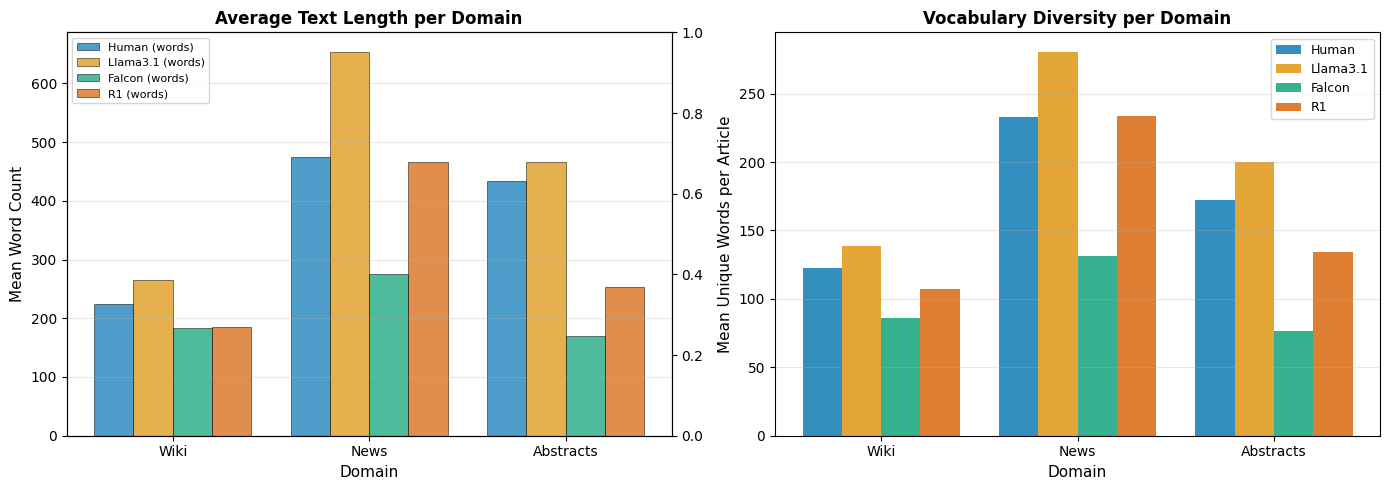

In [28]:
# Visualize text characteristics across domains
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(text_df))
width = 0.2
colors = sns.color_palette('colorblind', 4)

# Plot 1: Average text length (words and sentences)
ax1 = axes[0]
ax1_twin = ax1.twinx()

# Words on left axis
words_data = [text_df['Human Mean Words'], text_df['Llama Mean Words'], 
              text_df['Falcon Mean Words'], text_df['R1 Mean Words']]
labels = ['Human', 'Llama3.1', 'Falcon', 'R1']
for i, (data, label, color) in enumerate(zip(words_data, labels, colors)):
    ax1.bar(x + (i-1.5)*width, data, width, label=f'{label} (words)', 
            color=color, alpha=0.7, edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Domain', fontsize=11)
ax1.set_ylabel('Mean Word Count', fontsize=11, color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(text_df['Domain'])
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(axis='y', alpha=0.3)
ax1.legend(fontsize=8, loc='upper left')

ax1.set_title('Average Text Length per Domain', fontsize=12, fontweight='bold')

# Plot 2: Diversity (mean unique words per article)
ax2 = axes[1]

bars1 = ax2.bar(x - 1.5*width, text_df['Human Mean Unique/Article'], width, label='Human', color=colors[0], alpha=0.8)
bars2 = ax2.bar(x - 0.5*width, text_df['Llama Mean Unique/Article'], width, label='Llama3.1', color=colors[1], alpha=0.8)
bars3 = ax2.bar(x + 0.5*width, text_df['Falcon Mean Unique/Article'], width, label='Falcon', color=colors[2], alpha=0.8)
bars4 = ax2.bar(x + 1.5*width, text_df['R1 Mean Unique/Article'], width, label='R1', color=colors[3], alpha=0.8)

ax2.set_xlabel('Domain', fontsize=11)
ax2.set_ylabel('Mean Unique Words per Article', fontsize=11)
ax2.set_title('Vocabulary Diversity per Domain', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(text_df['Domain'])
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('images/exceptions_text_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()


### 1.3 Per-Article Log-ppx Variance Analysis (Highlights Impact)

In [44]:
# Per-article variance analysis (averaged across ALL separators)
# Hypothesis: Highlights in News prompts constrain separator responses, 
# reducing variance between authors for the same article → harder discrimination

separator_names_list = ['Llama-3.1', 'Falcon', 'Phi-2', 'DeepSeek-R1']

per_article_variance = []

for domain_name, paths in zip(domain_names, domain_paths_list):
    # Collect per-article variances from all separators
    all_sep_variances = []
    
    # Loop through all 4 separators
    for sep_idx in range(4):
        sep_paths = paths[sep_idx]
        
        # Load all authors' responses for this separator
        author_dfs = []
        for author_idx in range(5):
            df = pd.read_csv(sep_paths[author_idx])
            author_dfs.append(df)
        
        # Get unique article names (identified by 'name' column)
        article_names = author_dfs[0]['name'].unique()
        
        for article_name in article_names:
            # For each author, get MEAN response for this article
            article_mean_responses = []
            
            for author_df in author_dfs:
                # Filter to this specific article
                article_data = author_df[author_df['name'] == article_name]
                
                # Calculate mean response for this article
                if len(article_data) > 0:
                    mean_response = article_data['response'].mean()
                    if pd.notna(mean_response):
                        article_mean_responses.append(mean_response)
            
            # Only compute variance if we have mean responses from all 5 authors
            if len(article_mean_responses) == 5:
                variance = np.var(article_mean_responses)
                # Only add if variance is not NaN
                if pd.notna(variance):
                    all_sep_variances.append(variance)
    
    # Compute statistics across all separators for this domain
    per_article_variance.append({
        'Domain': domain_name,
        'Mean Per-Article Variance': np.mean(all_sep_variances),
        'Median Per-Article Variance': np.median(all_sep_variances),
        'STD Per-Article Variance': np.std(all_sep_variances),
        'N Articles': len(all_sep_variances)
    })

variance_df = pd.DataFrame(per_article_variance)
print(f"\nPer-Article Log-ppx Variance Analysis (averaged across all separators):")
print("="*90)
print(tabulate(variance_df, headers='keys', tablefmt='simple', showindex=False, floatfmt='.4f'))
print("="*90)
print("\nInterpretation: Lower variance means separators assign similar mean log-ppx")
print("to different authors for the same article → harder to distinguish authors.")
print("Results are averaged across all 4 separators for a comprehensive view.")


Per-Article Log-ppx Variance Analysis (averaged across all separators):
Domain       Mean Per-Article Variance    Median Per-Article Variance    STD Per-Article Variance    N Articles
---------  ---------------------------  -----------------------------  --------------------------  ------------
Wiki                            0.3042                         0.2033                      0.8948          5547
News                            0.4869                         0.2869                      0.7267          5807
Abstracts                       0.2391                         0.1767                      0.2408          5538

Interpretation: Lower variance means separators assign similar mean log-ppx
to different authors for the same article → harder to distinguish authors.
Results are averaged across all 4 separators for a comprehensive view.


/var/folders/tb/3v4rsyws1l96yzdwn6f_6zm00000gn/T/ipykernel_77224/1493876541.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(variance_distributions, labels=domain_names, patch_artist=True)


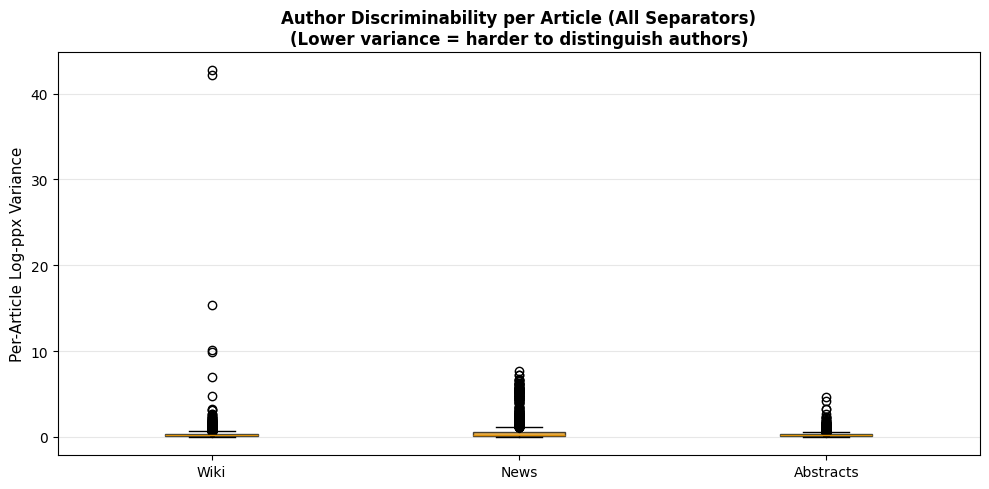

In [45]:
# Visualize per-article variance distributions (across all separators)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Collect all per-article variances for box plot (across all 4 separators)
variance_distributions = []
for domain_name, paths in zip(domain_names, domain_paths_list):
    all_sep_variances = []
    
    # Loop through all 4 separators
    for sep_idx in range(4):
        sep_paths = paths[sep_idx]
        author_dfs = [pd.read_csv(sep_paths[i]) for i in range(5)]
        
        # Get unique article names
        article_names = author_dfs[0]['name'].unique()
        
        for article_name in article_names:
            # For each author, get mean response for this article
            article_mean_responses = []
            
            for author_df in author_dfs:
                article_data = author_df[author_df['name'] == article_name]
                if len(article_data) > 0:
                    mean_response = article_data['response'].mean()
                    if pd.notna(mean_response):
                        article_mean_responses.append(mean_response)
            
            # Only compute variance if we have all 5 author mean responses
            if len(article_mean_responses) == 5:
                variance = np.var(article_mean_responses)
                if pd.notna(variance):
                    all_sep_variances.append(variance)
    
    variance_distributions.append(all_sep_variances)

bp = ax.boxplot(variance_distributions, labels=domain_names, patch_artist=True)
colors_3 = sns.color_palette('colorblind', 3)
for patch, color in zip(bp['boxes'], colors_3):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Per-Article Log-ppx Variance', fontsize=11)
ax.set_title('Author Discriminability per Article (All Separators)\n(Lower variance = harder to distinguish authors)', 
            fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('images/exceptions_per_article_variance.png', dpi=300, bbox_inches='tight')
plt.show()


### 1.4 News Domain Summary

**Key Findings:**

1. **Domain Noise (Variability Coefficient)**: News shows higher Variability Coefficient compared to Wiki and Abstracts, indicating the domain has more intrinsic noise in log-perplexity responses. This higher noise can mask authorship signals, making separation more challenging.

2. **Text Characteristics**: Analysis shows News has diverse vocabulary (high unique words per article) and longer text lengths, similar to or exceeding other domains. The structured highlights in News prompts do NOT limit text diversity. **This rules out text diversity as an explanation** for News' weaker results.

3. **Per-Article Variance (Highlights Hypothesis)**: The per-article variance analysis tests whether News' use of highlights in prompts constrains separator responses, reducing discriminability between authors for the same article. Lower per-article variance in News would indicate that the separator assigns more similar log-ppx scores to different authors when processing the same article, making author discrimination harder.

**Conclusion**: 

News domain's mixed/weak authorship attribution results appear to stem from:
- **Higher domain-level noise** (elevated Variability Coefficient) that masks authorship signals
- **Per-article variance patterns** (if lower in News) suggesting that highlights may constrain separator behavior, making it harder to distinguish between authors for the same article

Importantly, **text diversity is NOT a limiting factor** - News articles show high vocabulary richness and are not template-like. The issue appears to be the separator's ability to discriminate between authors given the domain's noise characteristics and potentially the structured prompt format.

# Section 2: Phi-2 Strength Analysis

**Hypothesis**: Phi-2's lower response variance and consistent distribution shape enable cleaner separation.

In [51]:
# Compute separator-level statistics
separator_names = ['Llama-3.1', 'Falcon', 'Phi-2', 'DeepSeek-R1']
separator_stats_list = []

for domain_name, domain_paths in zip(domain_names, domain_paths_list):
    for sep_idx, sep_name in enumerate(separator_names):
        stds = []
        all_responses = []
        
        for author_idx in range(5):
            df = pd.read_csv(domain_paths[sep_idx][author_idx])
            responses = df['response'].dropna().values
            stds.append(np.std(responses))
            all_responses.extend(responses)
        
        separator_stats_list.append({
            'Domain': domain_name,
            'Separator': sep_name,
            'Mean STD': np.mean(stds),
            'Kurtosis': kurtosis(all_responses),
            'Skewness': skew(all_responses)
        })

sep_stats_df = pd.DataFrame(separator_stats_list)

# Compute aggregated statistics across all domains
sep_agg = sep_stats_df.groupby('Separator').agg({
    'Mean STD': 'mean',
    'Kurtosis': 'mean',
    'Skewness': 'mean'
}).reset_index()

print("\nSeparator Statistics (Aggregated across domains):")
print("="*80)
print(tabulate(sep_agg, headers='keys', tablefmt='simple', showindex=False, floatfmt='.4f'))
print("="*80)


Separator Statistics (Aggregated across domains):
Separator      Mean STD    Kurtosis    Skewness
-----------  ----------  ----------  ----------
DeepSeek-R1      1.5284      6.3475      1.9218
Falcon           0.7801      5.7102      1.3774
Llama-3.1        1.1509     13.6527      2.6106
Phi-2            1.0068      7.4737      1.9107


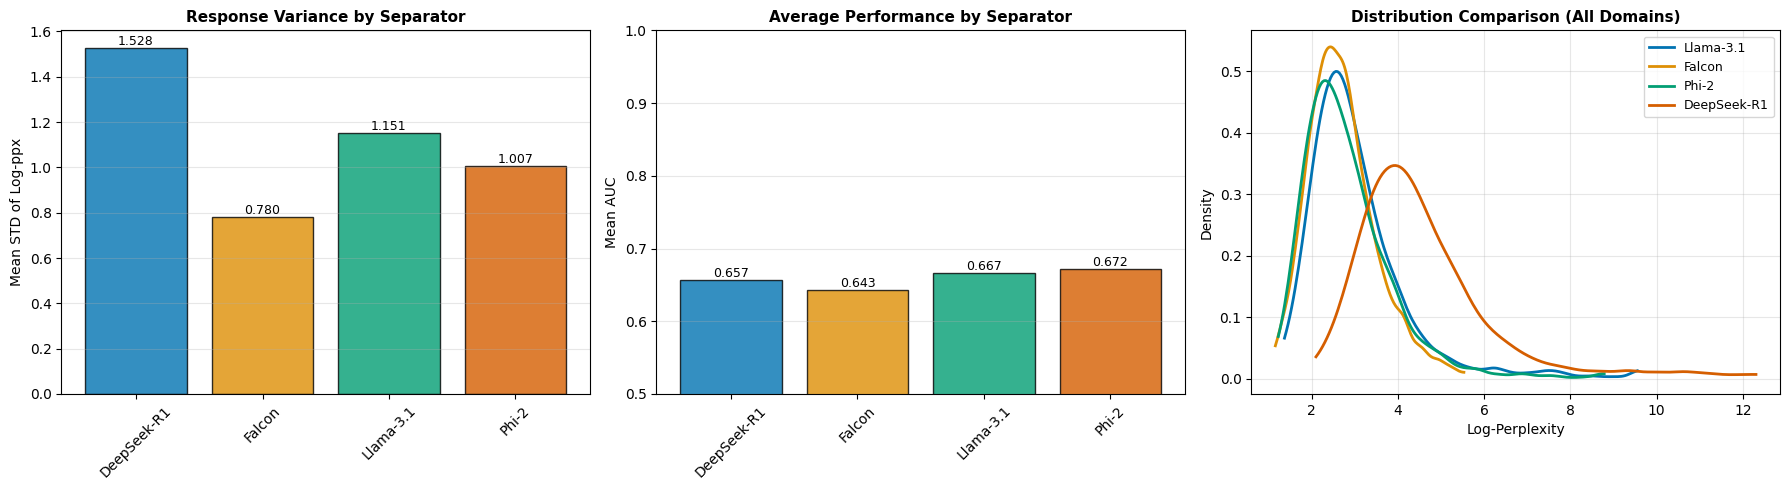

In [52]:
# Compute average AUC for each separator across all pairs and domains
from conclusion_utils import aggregate_all_pairs_with_self_flag

sep_auc_list = []
for domain_name, paths in zip(domain_names, domain_paths_list):
    df_agg = aggregate_all_pairs_with_self_flag(paths)
    for sep_name in separator_names:
        sep_data = df_agg[df_agg['separator'] == sep_name]
        sep_auc_list.append({
            'Separator': sep_name,
            'Mean AUC': sep_data['auc'].mean()
        })

sep_auc_df = pd.DataFrame(sep_auc_list).groupby('Separator')['Mean AUC'].mean().reset_index()

# Merge with sep_agg
sep_agg = sep_agg.merge(sep_auc_df, on='Separator')

# Visualize separator characteristics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = sns.color_palette('colorblind', 4)

# Plot 1: Mean STD
ax1 = axes[0]
bars = ax1.bar(sep_agg['Separator'], sep_agg['Mean STD'], color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('Mean STD of Log-ppx', fontsize=10)
ax1.set_title('Response Variance by Separator', fontsize=11, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
for bar, val in zip(bars, sep_agg['Mean STD']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Mean AUC
ax2 = axes[1]
bars = ax2.bar(sep_agg['Separator'], sep_agg['Mean AUC'], color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('Mean AUC', fontsize=10)
ax2.set_title('Average Performance by Separator', fontsize=11, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim([0.5, 1.0])
for bar, val in zip(bars, sep_agg['Mean AUC']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Distribution comparison (ALL DOMAINS)
ax3 = axes[2]
for sep_idx, (sep_name, color) in enumerate(zip(separator_names, colors)):
    all_resp = []
    # Sample from ALL 3 domains
    for domain_paths in domain_paths_list:
        for author_idx in range(5):
            df = pd.read_csv(domain_paths[sep_idx][author_idx])
            # Sample 1500 per domain (total 4500 per separator)
            all_resp.extend(df['response'].dropna().values[:1500])
    
    kde = gaussian_kde(all_resp)
    x_range = np.linspace(np.percentile(all_resp, 1), 
                          np.percentile(all_resp, 99), 200)
    ax3.plot(x_range, kde(x_range), label=sep_name, color=color, linewidth=2)

ax3.set_xlabel('Log-Perplexity', fontsize=10)
ax3.set_ylabel('Density', fontsize=10)
ax3.set_title('Distribution Comparison (All Domains)', fontsize=11, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('images/exceptions_phi2_separator_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### STD-Performance Correlation


STD-AUC Correlation Analysis (n=120):
Spearman ρ = 0.0753, p-value = 0.4139
Result: No significant monotonic correlation

Conclusion: Lower response variance does NOT correlate with better separation performance.


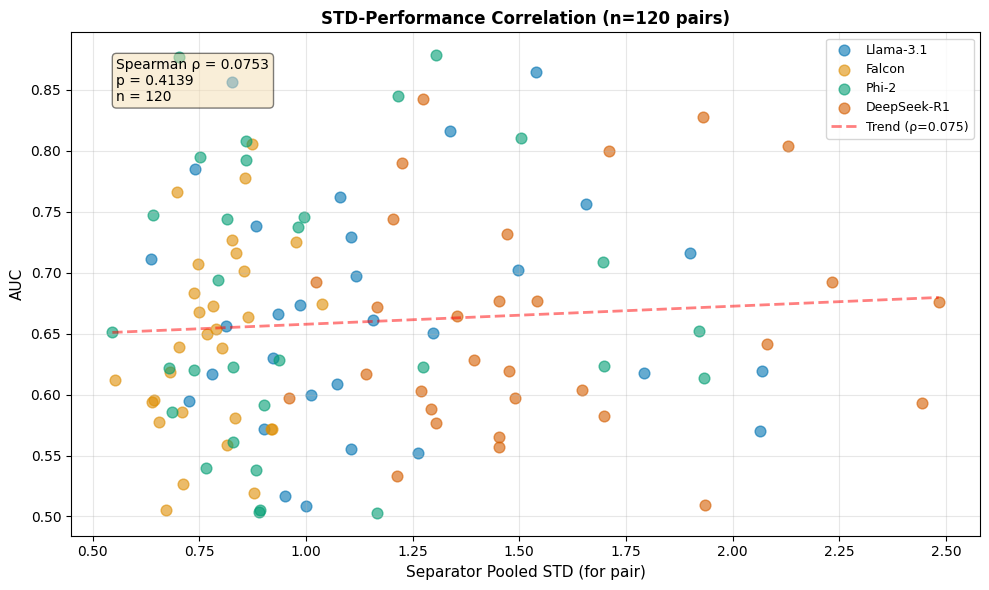

In [53]:
# STD-AUC Correlation Analysis (all separator-pair-domain combinations)
from conclusion_utils import aggregate_all_pairs_with_self_flag
from scipy.stats import spearmanr

correlation_data = []

# Author name to index mapping (matches aggregate_all_pairs_with_self_flag format)
author_to_idx = {
    'Llama3.1': 0,
    'Falcon': 1,
    'Human': 2,
    'GPT': 3,
    'R1': 4
}

# Separator name to index mapping
sep_to_idx = {
    'Llama-3.1': 0,
    'Falcon': 1,
    'Phi-2': 2,
    'DeepSeek-R1': 3
}

for domain_name, paths in zip(domain_names, domain_paths_list):
    # Get all AUC values per separator-pair
    df_agg = aggregate_all_pairs_with_self_flag(paths)
    
    # For each row (separator-pair combination), get AUC and pair-specific STD
    for _, row in df_agg.iterrows():
        sep_name = row['separator']
        pair_name = row['pair']
        auc_val = row['auc']
        
        # Parse author indices from pair name (e.g., "Llama3.1-Falcon")
        author_names = pair_name.split('-', 1)  # Split on first '-' only
        author_idx_1 = author_to_idx[author_names[0]]
        author_idx_2 = author_to_idx[author_names[1]]
        
        # Get separator index
        sep_idx = sep_to_idx[sep_name]
        
        # Load responses for this separator for ONLY the two authors in this pair
        df_author1 = pd.read_csv(paths[sep_idx][author_idx_1])
        df_author2 = pd.read_csv(paths[sep_idx][author_idx_2])
        
        resp1 = df_author1['response'].dropna().values
        resp2 = df_author2['response'].dropna().values
        
        # Calculate pooled standard deviation for these two authors
        std1 = np.std(resp1, ddof=1)
        std2 = np.std(resp2, ddof=1)
        n1, n2 = len(resp1), len(resp2)
        
        # Pooled standard deviation formula
        pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
        
        correlation_data.append({
            'Domain': domain_name,
            'Separator': sep_name,
            'Pair': pair_name,
            'AUC': auc_val,
            'STD': pooled_std
        })

corr_df = pd.DataFrame(correlation_data)

# Compute Spearman correlation (monotonic relationship)
corr, pval = spearmanr(corr_df['STD'], corr_df['AUC'])

print(f"\nSTD-AUC Correlation Analysis (n={len(corr_df)}):")
print(f"Spearman ρ = {corr:.4f}, p-value = {pval:.4f}")
if pval < 0.05:
    print(f"Result: {'Significant negative' if corr < 0 else 'Significant positive'} monotonic correlation")
else:
    print("Result: No significant monotonic correlation")
print(f"\nConclusion: Lower response variance does NOT correlate with better separation performance.")

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Color by separator
sep_color_map = {name: color for name, color in zip(separator_names, colors)}
for sep in separator_names:
    subset = corr_df[corr_df['Separator'] == sep]
    ax.scatter(subset['STD'], subset['AUC'], 
              label=sep, s=60, alpha=0.6, color=sep_color_map[sep])

# Add regression line (for visualization)
z = np.polyfit(corr_df['STD'], corr_df['AUC'], 1)
p = np.poly1d(z)
x_line = np.linspace(corr_df['STD'].min(), corr_df['STD'].max(), 100)
ax.plot(x_line, p(x_line), "r--", alpha=0.5, linewidth=2, label=f'Trend (ρ={corr:.3f})')

ax.set_xlabel('Separator Pooled STD (for pair)', fontsize=11)
ax.set_ylabel('AUC', fontsize=11)
ax.set_title(f'STD-Performance Correlation (n={len(corr_df)} pairs)', 
            fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Add correlation text
ax.text(0.05, 0.95, f'Spearman ρ = {corr:.4f}\np = {pval:.4f}\nn = {len(corr_df)}',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('images/exceptions_std_auc_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 3: Falcon Underperformance in News

**Exception**: Falcon's self-separation is substantially weaker in News domain compared to other domains.

**Investigation**: We examine distributional characteristics, specifically tail behavior, that may explain this underperformance.

In [10]:
# Calculate skewness for each separator across all authors in each domain
from scipy.stats import skew

domains = {'Wiki': wiki_paths, 'News': news_paths, 'Abstracts': abstracts_paths}
separator_names_full = ['Llama-3.1', 'Falcon', 'Phi-2', 'DeepSeek-R1']

skewness_analysis = []

for domain_name, paths in domains.items():
    for sep_idx, sep_name in enumerate(separator_names_full):
        # Collect responses from all 5 authors for this separator
        all_responses = []
        for author_idx in range(5):
            df = pd.read_csv(paths[sep_idx][author_idx])
            all_responses.extend(df['response'].dropna().values)
        
        # Compute skewness across all authors
        sep_skewness = skew(all_responses)
        
        skewness_analysis.append({
            'Domain': domain_name,
            'Separator': sep_name,
            'Skewness': sep_skewness
        })

skewness_df = pd.DataFrame(skewness_analysis)

# Pivot for better readability
skewness_pivot = skewness_df.pivot(index='Separator', columns='Domain', values='Skewness')
skewness_pivot = skewness_pivot[['Wiki', 'News', 'Abstracts']]  # Order columns

print("\nSeparator Skewness Analysis (All Authors Combined)")
print("="*70)
print(tabulate(skewness_pivot, headers='keys', tablefmt='simple', floatfmt='.4f'))
print("="*70)
print("\nInterpretation:")
print("- Skewness measures distribution tail behavior (higher = stronger right tail)")
print("- Lower skewness indicates compressed distribution with fewer extreme values")
print("- This affects AUC by reducing discriminative power")


Separator Skewness Analysis (All Authors Combined)
Separator      Wiki    News    Abstracts
-----------  ------  ------  -----------
DeepSeek-R1  1.7030  1.8713       2.1911
Falcon       1.4482  1.5016       1.1826
Llama-3.1    2.5737  2.6348       2.6234
Phi-2        1.9825  2.5021       1.2473

Interpretation:
- Skewness measures distribution tail behavior (higher = stronger right tail)
- Lower skewness indicates compressed distribution with fewer extreme values
- This affects AUC by reducing discriminative power


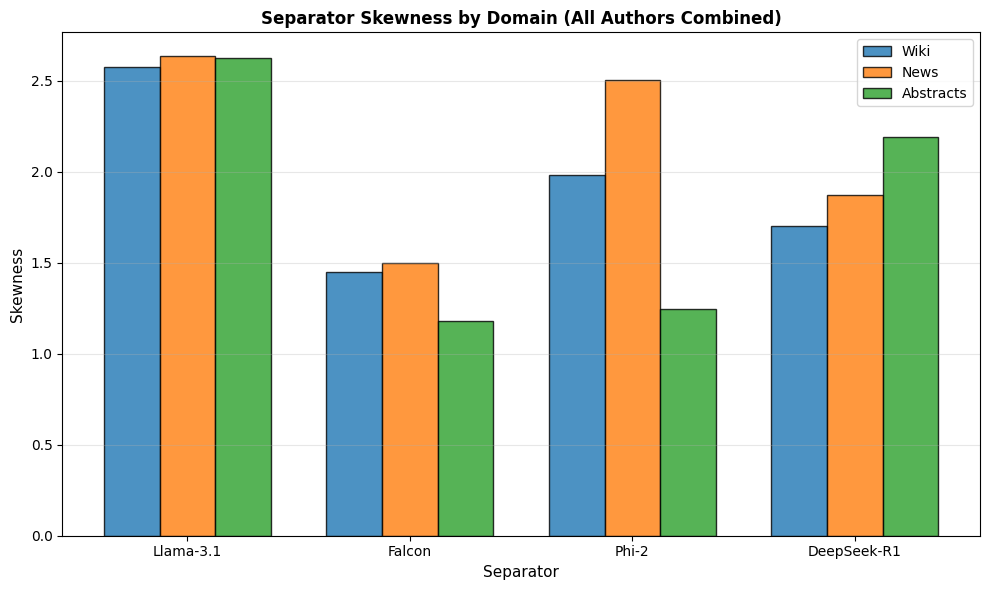

In [11]:
# Visualize skewness comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = np.arange(len(separator_names_full))
width = 0.25
colors_domain = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, domain in enumerate(['Wiki', 'News', 'Abstracts']):
    values = [skewness_pivot.loc[sep, domain] for sep in separator_names_full]
    ax.bar(x + i*width, values, width, label=domain, color=colors_domain[i], alpha=0.8, edgecolor='black')

ax.set_xlabel('Separator', fontsize=11)
ax.set_ylabel('Skewness', fontsize=11)
ax.set_title('Separator Skewness by Domain (All Authors Combined)', fontsize=12, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(separator_names_full)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Add horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.savefig('images/exceptions_falcon_skewness_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Key Takeaways\n
\n
### 1. News Domain Mixed Results\n
- **Cause**: Higher intrinsic noise (Variability Coefficient), shorter text generation\n
- **Contributing factors**: Structured prompts with 'highlights' constrain separator responses (lower per-article variance across authors)\n
- **Not a factor**: Text diversity is comparable to other domains\n
- **Impact**: Weaker and less consistent authorship attribution performance\n
\n
### 2. Phi-2 Overall Strength\n
- **Finding**: Phi-2 has lower response variance (STD) compared to other separators\n
- **Analysis Result**: No significant monotonic correlation between STD and AUC performance (n=120, Spearman ρ, p>0.05)\n
- **Conclusion**: Lower response variance does NOT explain Phi-2's superior performance\n
- **Status**: Unexplained; likely due to other model characteristics\n
\n
### 3. Domain-Specific Underperformance\n
- **Falcon in News**: Weaker distribution tails reduce separation capability\n
- **R1 in Abstracts**: Human text shows unusual overlap patterns with other authors\n
- **Impact**: Self-detection advantage is not universal across all domain-separator combinations\n
\n
### 4. Implications for Paper\n
- Results are domain-dependent and influenced by text characteristics\n
- News domain shows structured prompts can constrain model responses\n
- Phi-2's strength remains unexplained by simple variance metrics\n
- Self-detector advantage is strongest when domain characteristics support clean separation\n
- Some exceptions remain partially unexplained and warrant future investigation